In [43]:
%pip install -q scikit-image opencv-python

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [194]:
import numpy as np
import cv2  # импортирую ИСКЛЮЧИТЕЛЬНО для проверки правильно написанных мною функций

from time import time

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [22]:
def interpolate(img, x, y, interpolation_type="NN"):
    '''
    img: исходное изображение
    x, y: координаты точек (float), значения в которых нужно интерполировать
    interpolation_type: способы интеполяции `NN` (nearest neighbour) или `Bilinear`
    '''
    assert x.shape == y.shape
    
    H, W = img.shape[:2]
    C = 1 if len(img.shape) == 2 else img.shape[-1]
    if C == 1:
        img = np.expand_dims(img, axis=2)
        
    new_H, new_W = x.shape
    
    if interpolation_type == "NN":
        x = x.round().astype(np.int32)
        y = y.round().astype(np.int32)
        
        cond = (0 <= x) & (x < H) & (0 <= y) & (y < W)
        
        x = np.clip(x, 0, H - 1)
        y = np.clip(y, 0, W - 1)
        
        return np.where(
            np.expand_dims(cond, axis=2).repeat(C, axis=2),
            img[x, y],
            0,
        ).squeeze()
        
    elif interpolation_type == "Bilinear":
        cond = (0 <= x) & (x < H) & (0 <= y) & (y < W)
        
        x1 = np.floor(x).astype(np.int32)
        x2 = np.ceil(x).astype(np.int32)
        x1 = np.where((x1 == x2) & (x1 > 0), x1 - 1, x1)
        x2 = np.where((x1 == x2) & (x1 == 0), x2 + 1, x2)
        
        y1 = np.floor(y).astype(np.int32)
        y2 = np.ceil(y).astype(np.int32)
        y1 = np.where((y1 == y2) & (y1 > 0), y1 - 1, y1)
        y2 = np.where((y1 == y2) & (y1 == 0), y2 + 1, y2)
        
        x = np.clip(x, 0, H - 1)
        x1 = np.clip(x1, 0, H - 1)
        x2 = np.clip(x2, 0, H - 1)
        
        y = np.clip(y, 0, W - 1)
        y1 = np.clip(y1, 0, W - 1)
        y2 = np.clip(y2, 0, W - 1)
        
        Q11 = np.expand_dims(img[x1, y1], axis=2)
        Q12 = np.expand_dims(img[x1, y2], axis=2)
        Q21 = np.expand_dims(img[x2, y1], axis=2)
        Q22 = np.expand_dims(img[x2, y2], axis=2)
        
        interpolation = np.einsum(
            'hwj,hwjkc,hwk->hwc',
            np.stack((x2 - x, x - x1), axis=-1),
            np.stack((Q11, Q12, Q21, Q22), axis=2).reshape((new_H, new_W, 2, 2, C)),
            np.stack((y2 - y, y - y1), axis=-1),
        )
        
        result = np.where(
            np.expand_dims(cond, axis=2).repeat(C, axis=2),
            interpolation,
            0,
        )
        result = np.round(result).astype(np.uint8).squeeze()
        return np.clip(result, 0, 255)
        
    raise ValueError("incorrect interpolation type")

In [23]:
def rotate_img(img, alpha, interpolation_type="NN"):
    H, W = img.shape[:2]
    
    alpha_0 = np.arctan2(H, W)
    diag = np.sqrt(H**2 + W**2)
    new_H = int(np.ceil(abs(diag * np.sin(abs(alpha) + alpha_0))))
    new_W = int(np.ceil(abs(diag * np.sin(np.pi / 2 - abs(alpha) + alpha_0))))
    new_center = np.array((new_H / 2, new_W / 2))
    
    new_points = np.stack(np.mgrid[0:new_H, 0:new_W], axis=-1)
    rotation_matrix = np.array([
        [np.cos(alpha), np.sin(alpha)],
        [-np.sin(alpha), np.cos(alpha)],
    ])
    
    center = np.array((H / 2, W / 2))
    points = np.einsum('jk,hwk->hwj', rotation_matrix, new_points - new_center) + center
    
    return interpolate(img, points[:, :, 0], points[:, :, 1], interpolation_type=interpolation_type)

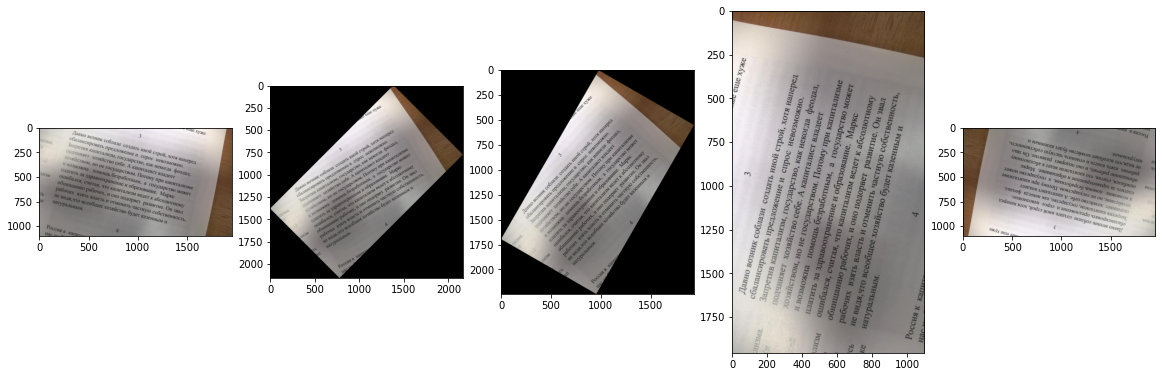

In [24]:
img = plt.imread("images/1.jpg")
plt.figure(figsize=(20, 20))
plt.subplot(1, 5, 1)
plt.imshow(img)
plt.subplot(1, 5, 2)
plt.imshow(rotate_img(img, np.pi/4, interpolation_type="Bilinear"))
plt.subplot(1, 5, 3)
plt.imshow(rotate_img(img, np.pi/3, interpolation_type="Bilinear"))
plt.subplot(1, 5, 4)
plt.imshow(rotate_img(img, np.pi/2, interpolation_type="Bilinear"))
plt.subplot(1, 5, 5)
plt.imshow(rotate_img(img, np.pi, interpolation_type="Bilinear"))
plt.show()

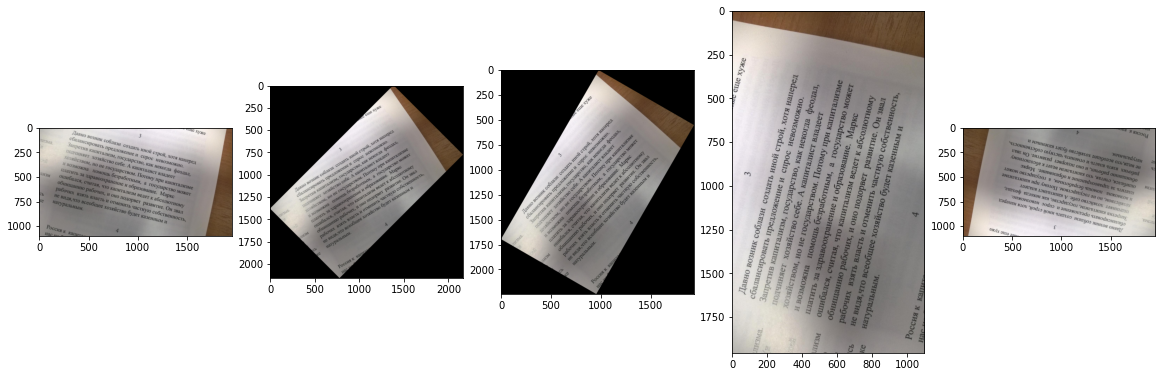

In [25]:
img = plt.imread("images/1.jpg")
plt.figure(figsize=(20, 10))
plt.subplot(1, 5, 1)
plt.imshow(img)
plt.subplot(1, 5, 2)
plt.imshow(rotate_img(img, np.pi/4))
plt.subplot(1, 5, 3)
plt.imshow(rotate_img(img, np.pi/3))
plt.subplot(1, 5, 4)
plt.imshow(rotate_img(img, np.pi/2))
plt.subplot(1, 5, 5)
plt.imshow(rotate_img(img, np.pi))
plt.show()

In [28]:
def resize_img(img, new_H=None, new_W=None, interpolation_type="NN"):
    assert new_H is not None or new_W is not None, "at least one shape should be known"
    
    H, W = img.shape[:2]
    if new_H is None:
        new_H = H * new_W // W
    elif new_W is None:
        new_W = W * new_H // H
    
    new_points = np.stack(np.mgrid[0:new_H, 0:new_W], axis=-1)
    points = new_points * np.array([H / new_H, W / new_W])
    
    return interpolate(img, points[:, :, 0], points[:, :, 1], interpolation_type=interpolation_type)

(1100, 1954, 3)


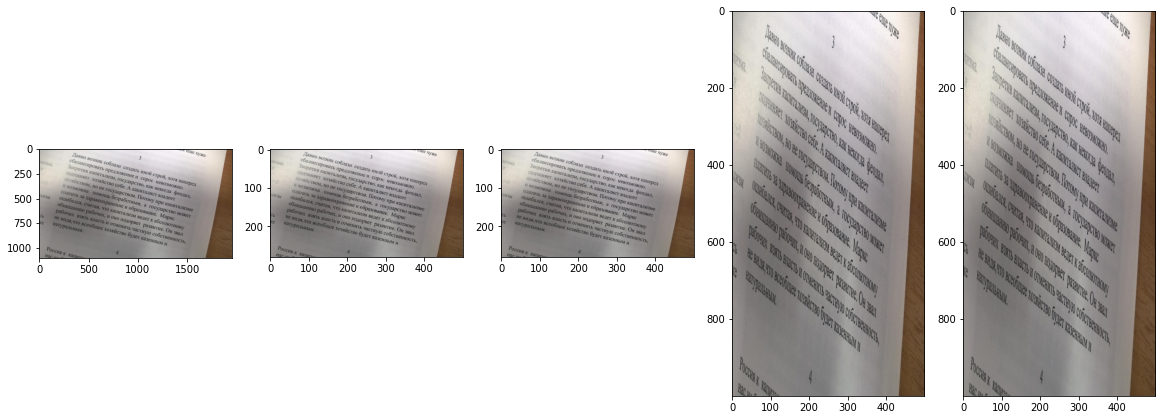

In [30]:
img = plt.imread("images/1.jpg")
print(img.shape)

plt.figure(figsize=(20, 10))
plt.subplot(1, 5, 1)
plt.imshow(img)
plt.subplot(1, 5, 2)
plt.imshow(resize_img(img, new_W = 500))
plt.subplot(1, 5, 3)
plt.imshow(resize_img(img, new_W = 500, interpolation_type="Bilinear"))
plt.subplot(1, 5, 4)
plt.imshow(resize_img(img, new_H=1000, new_W=500))
plt.subplot(1, 5, 5)
plt.imshow(resize_img(img, new_H=1000, new_W=500, interpolation_type="Bilinear"))
plt.show()

In [52]:
def get_intensity(img, ):
    '''
    img: np.array with shape (H, W, 3)
    '''
    
    return (img @ np.array([0.299, 0.587, 0.114])).squeeze().round().astype(np.uint8)

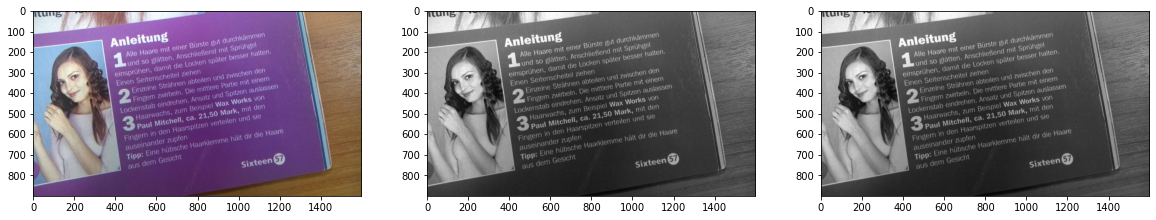

0

In [54]:
img = plt.imread("images/2.jpg")
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.subplot(1, 3, 2)
plt.imshow(get_intensity(img), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cmap='gray')
plt.show()

((get_intensity(img) - cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))**2).sum()

### Fast Hough Transform

Моя реализация идет сверху вниз, а не слева направо, как в статье. Мне так было идейно проще понять + проще реализоывать

In [340]:
def FHT(intensity, start=None, end=None, final=True,):
    '''
    intensity: HxW изображение со значением интенсивности
    start: начало вычисления (нужно для рекурсивного вызова)
    end: конец вычисления (нужно для рекурсивного вызова)
    '''
    
    H, W = intensity.shape
    
    if start is None:
        start = 0
    if end is None:
        end = H
        
    assert 0 <= start < end <= H
    
    if (end - start) == 1:
        return (
            np.expand_dims(np.pad(intensity[start], (H, H), 'constant', constant_values=0), axis=-1).repeat(2, axis=-1),
            np.expand_dims(np.pad(np.ones_like(intensity[start], dtype=np.int32), (H, H), 'constant', constant_values=0), axis=-1).repeat(2, axis=-1),
        )
    
    middle = (end + start) // 2
    upper_sum, upper_cnt = FHT(intensity, start=start, end=middle, final=False)
    lower_sum, lower_cnt = FHT(intensity, start=middle, end=end, final=False)
    
    center = end - start
    result_sum = np.zeros((2*H + W, 2 * center), dtype=np.float32)
    result_cnt = np.zeros((2*H + W, 2 * center), dtype=np.int32)
    
    result_sum[:, 0::2] += upper_sum
    result_sum[:, 1::2] += upper_sum
    result_cnt[:, 0::2] += upper_cnt
    result_cnt[:, 1::2] += upper_cnt
    
    # сложная игра с индексами
    for shift in range(result_sum.shape[1]):
        delta = shift - center
        real_shift = delta + (delta < 0)

        begin = np.arange(result_sum.shape[0])
        lower_begin = begin + (delta + 1) // 2
        cond = (0 <= lower_begin) & (lower_begin < result_sum.shape[0])

        begin = begin[cond]
        lower_begin = lower_begin[cond]
        result_sum[begin, shift] += lower_sum[lower_begin, shift // 2]
        result_cnt[begin, shift] += lower_cnt[lower_begin, shift // 2]
    
    if final:
        return result_sum / np.where(result_cnt == 0, 1, result_cnt)
    return (result_sum, result_cnt)

In [349]:
real_img = plt.imread("images/1.jpg")
img = resize_img(real_img, *(2**np.ceil(np.log2(real_img.shape[:2])).astype(np.int32)))
img = get_intensity(img)
img.shape

(2048, 2048)

In [350]:
%%time
res = FHT(img.T.astype(np.float32))
res = res[img.shape[1]:-img.shape[1]] / 255
res.shape, res.min(), res.max()

CPU times: user 13.1 s, sys: 500 ms, total: 13.6 s
Wall time: 13.5 s


((2048, 4096), 0.3658854166666667, 0.890495642701525)

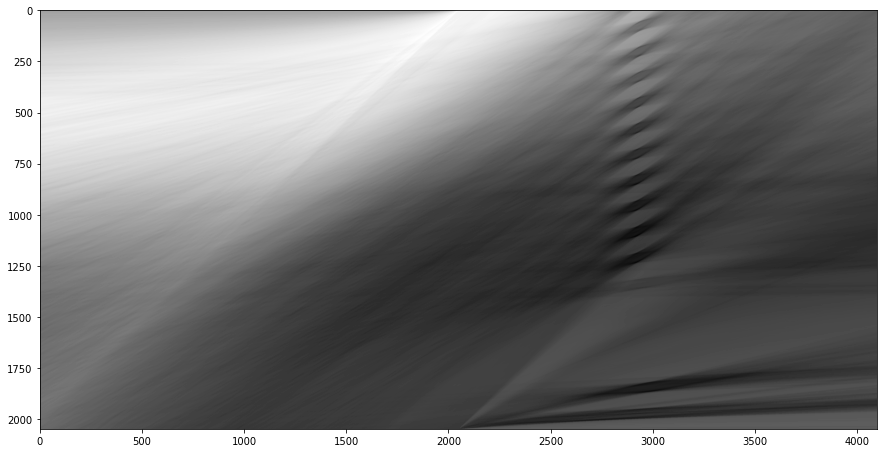

In [351]:
plt.figure(figsize=(15, 15))
plt.imshow(res, cmap='gray')
plt.show()

In [352]:
shift = np.argmax(np.var(res, axis=0))
delta = shift - res.shape[1] // 2
real_shift = delta + (delta < 0)

real_H, real_W = real_img.shape[:2]
H, W = img.shape

ratio = (real_shift * real_H / H) / W
ratio, np.arctan(ratio)

(-0.12955665588378906, -0.12883900324481037)

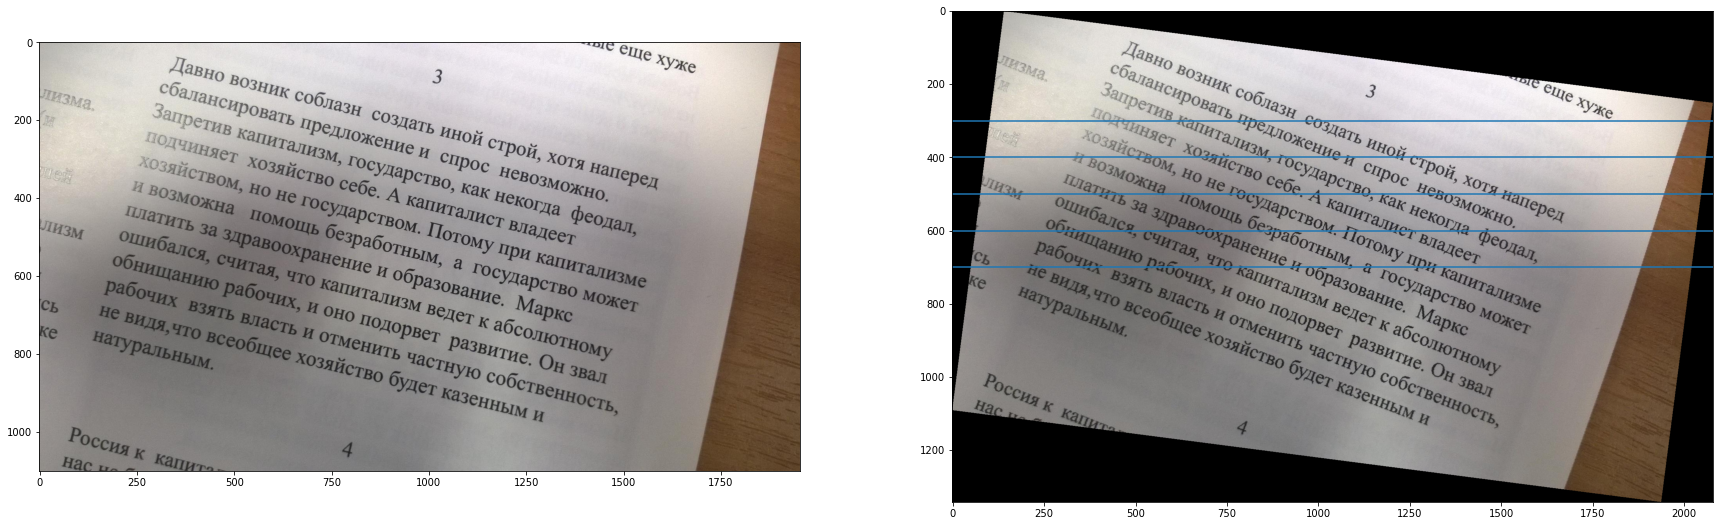

In [354]:
plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
plt.imshow(real_img)
plt.subplot(1, 2, 2)
plt.imshow(rotate_img(real_img, np.arctan(ratio)))
plt.axhline(300)
plt.axhline(400)
plt.axhline(500)
plt.axhline(600)
plt.axhline(700)
plt.show()

In [301]:
def crop_img(img, alpha=0.25):
    H, W = img.shape[:2]
    return img[int(H * alpha):-int(H * alpha), int(W * alpha):-int(W * alpha)]

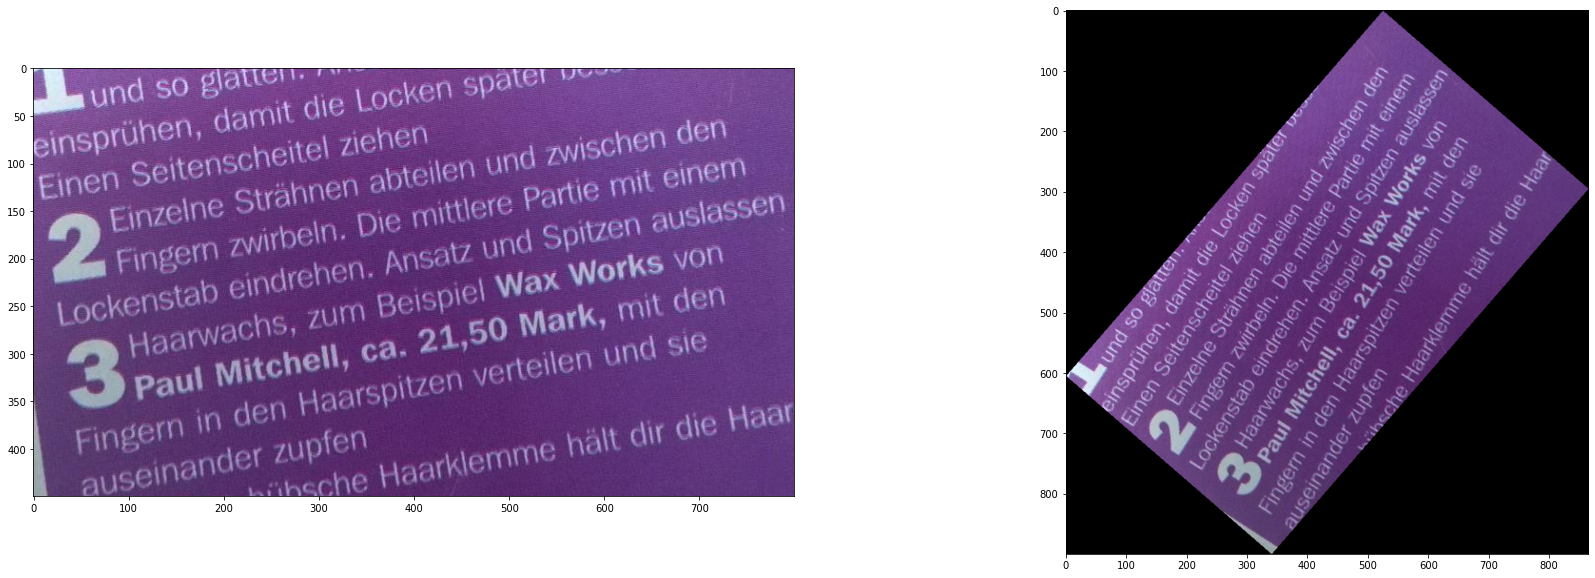

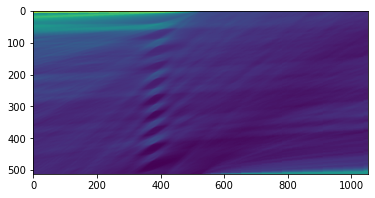

In [326]:
max_angle = 30 / 180 * np.pi

original_img = plt.imread("images/2.jpg")
cropped_img = crop_img(original_img)

img = get_intensity(cropped_img)
img = resize_img(img, *(2**np.ceil(np.log2(img.shape[:2])).astype(np.int32)))

res = FHT(img.T.astype(np.float32))
res = res[img.shape[1]:-img.shape[1]] / 255

max_shift = np.tan(max_angle) * cropped_img.shape[1] * img.shape[0] / cropped_img.shape[0]
all_shifts = np.concatenate([-np.arange(res.shape[1] // 2)[::-1], np.arange(res.shape[1] // 2)])
condition = np.abs(all_shifts) < max_shift
all_shifts = all_shifts[condition]
res = res[:, condition]

shift = all_shifts[np.argmax(np.var(res, axis=0))]
delta = shift - (res.shape[1] // 2)
real_shift = delta + (delta < 0)

angle = np.arctan2((real_shift * cropped_img.shape[0] / img.shape[0]), cropped_img.shape[1])

plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
plt.imshow(cropped_img)
plt.subplot(1, 2, 2)
plt.imshow(rotate_img(cropped_img, -angle))
plt.show()

plt.imshow(res)

In [330]:
np.var(res, axis=0)[370:400]

array([0.00897696, 0.00905586, 0.00906195, 0.0091371 , 0.00906045,
       0.00912721, 0.00912881, 0.00918858, 0.00918872, 0.00923346,
       0.00922811, 0.00925659, 0.00909691, 0.00909897, 0.00907844,
       0.00906148, 0.00904738, 0.00901404, 0.00898432, 0.00894204,
       0.00885866, 0.00880556, 0.00876681, 0.00870787, 0.00868159,
       0.00861614, 0.00856527, 0.0084958 , 0.00822845, 0.00815505])

In [329]:
np.var(res, axis=0)[:10]

array([0.01131087, 0.01130906, 0.01130247, 0.01130246, 0.01130608,
       0.01130623, 0.01123463, 0.01123449, 0.01123584, 0.0112356 ])

In [327]:
res.shape

(512, 1052)

In [328]:
np.argmax(np.var(res, axis=0)) - 1024

-1024

In [316]:
np.var(res, axis=0)[shift]

0.002495461221531647

In [314]:
np.var(res, axis=0)[1476]

0.005252409207358597

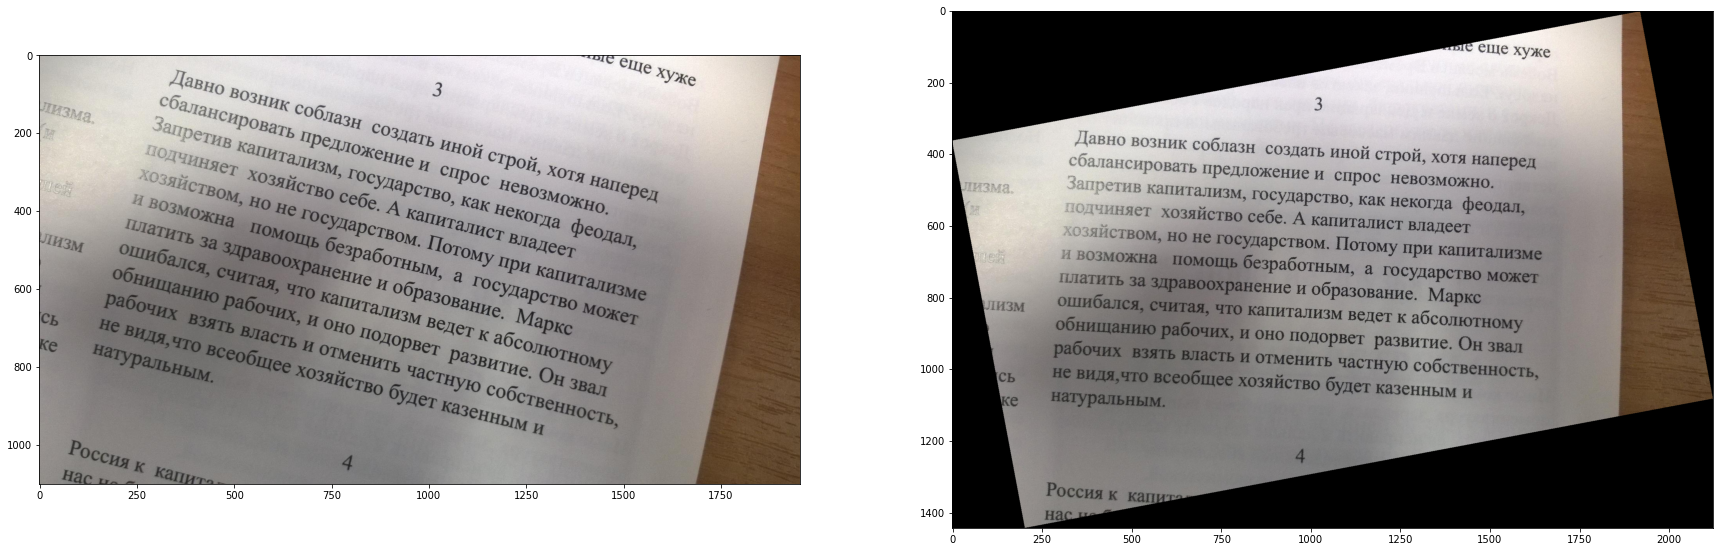

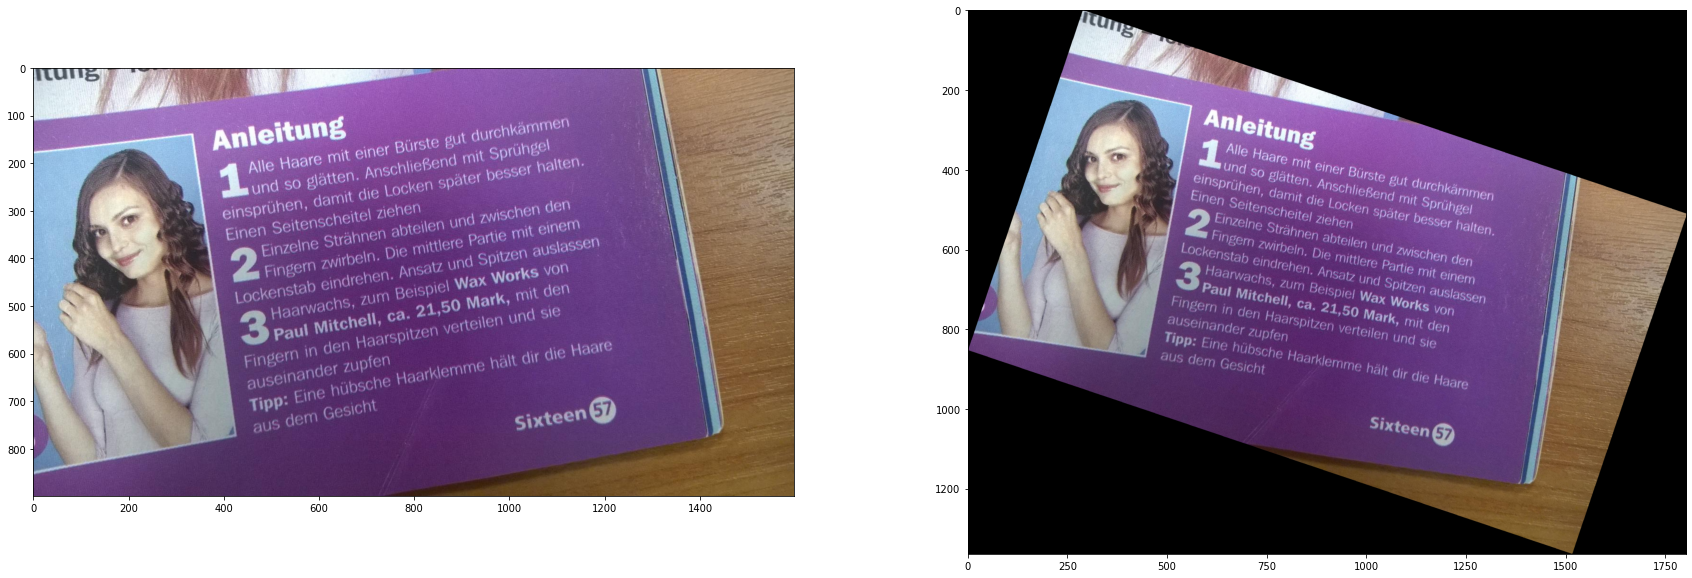

In [270]:
alpha_0 = 45 / 180 * np.pi

for k in range(1, 3):
    original_img = plt.imread(f"images/{k}.jpg")
    cropped_img = original_img[original_img.shape[0]//4:-original_img.shape[0]//4, original_img.shape[1]//4:-original_img.shape[1]//4]
    
    img = resize_img(cropped_img, *(2**np.ceil(np.log2(cropped_img.shape[:2])).astype(np.int32)))
    img = get_intensity(img)
    
    H, W = img.shape
    res = FHT(img.T.astype(np.float32))[W:-W]
    
    shifts = np.arange(res.shape[1])
    shifts_cond = np.abs(shifts - W) < (np.tan(alpha_0) * cropped_img.shape[1] * H / cropped_img.shape[0])
    shifts = shifts[shifts_cond]
    res = res[:, shifts_cond]

    shift = shifts[np.argmax(np.var(res, axis=0))]
    delta = shift - H
    real_shift = delta + (delta < 0)

    angle = np.arctan2(real_shift * real_H / H, W)

    plt.figure(figsize=(30, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.subplot(1, 2, 2)
    plt.imshow(rotate_img(original_img, angle))
    plt.show()